In [ ]:
# MULTICLASS ENGLISH TEXT CLASSIFICATION USING AN LSTM 

In [1]:
import pandas as pd # we need this package to manipulate data structues for data analysis and statistics
df = pd.read_csv("../../Datasets/MulticlassTextDataset.csv", delimiter=',', dtype='unicode') 

In [2]:
df.info()
df = df[pd.notnull(df['Consumer complaint narrative'])]
df = df[pd.notnull(df['Product'])]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938336 entries, 0 to 938335
Data columns (total 18 columns):
Date received                   938336 non-null object
Product                         938333 non-null object
Sub-product                     836747 non-null object
Issue                           938333 non-null object
Sub-issue                       698628 non-null object
Consumer complaint narrative    409889 non-null object
Company public response         469761 non-null object
Company                         938332 non-null object
State                           918873 non-null object
ZIP code                        822760 non-null object
Tags                            127572 non-null object
Consumer consent provided?      732020 non-null object
Submitted via                   938332 non-null object
Date sent to company            938332 non-null object
Company response to consumer    938331 non-null object
Timely response?                938332 non-null object
Consumer 

# TEXT PREPOCESSING : 1-CONSOLIDATION

In [5]:
#Visulaisation of the districution of data grouped by product
df['review_len'] = df['Consumer complaint narrative'].astype(str).apply(len)
### Those lines make sure that the df will accept to be a pandas dataframe type instead of being recognized as a series times . in order to use the iplot function ##
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
############################################################################################
#bar plot of the distribution
df.groupby("Product").count()['Complaint ID'].iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Distribution of the data by product', xTitle='product')

In [6]:
## CONSOLIDATION OF THE LABELs
#since some product label aren't having a lot of data, we are going to m
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [16]:
#bar plot of the distribution after consolidation
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

# TEXT PREPOCESSING : 2-CLEANING

In [ ]:

#import nltk #world's most relevant package to text processing
import re # package to regular expression to find , substract a substring from the text
from nltk.corpus import stopwords #package of predefined stop words available in nltk
from stop_words import get_stop_words # specified package of predefined stop words
from nltk.tokenize import sent_tokenize, word_tokenize # split the text into words/tokens

########################################################################################################
def cleaning_data (text) :
    #this function process to the cleaning by using regular expression
    #lover the text
    text= text.lower()
    #links
    text=re.sub('https://\S+','lien',text)
    text=re.sub('http\S+\s','lien',text)
    #email
    text=re.sub('\w+@\w+','',text)
    #ponctualtion
    text=re.sub('[%s]' % re.escape("""!"#/\$%&()*+',-.:;<=>?[]^_`{|}~°•"""), ' ', text)
    text=re.sub('[%s]' % re.escape('""'), ' ', text)
    text=re.sub('[%s]' % re.escape("'"), ' ', text)
    # remove special characters and digits
    text=re.sub("(\d)+"," ",text) 
    #remove +2 blank spaces
    text = re.sub('\s+', ' ', text)
    #words with 1 to 2 letters
    text= re.sub(r'\W*\b\w{1,2}\b', ' ', text)
    #after visualiting the data we find that xxxx and xxx was used a lot , so we gonna just remove it 
    text= re.sub('xxx', ' ', text)
    text= re.sub('xxxx', ' ', text)
    #stop words
    stopwords = get_stop_words('en') # stopwords from stopwords packages
    text = ' '.join(word for word in text.split() if word not in (stopwords))
                    
    ####or you can use the nltk collection of stopwords
    #set(stopwords.words('english'))
    #stop_words = set(stopwords.words('english'))  
    #text = ' '.join(word for word in text.split() if word not in (stop_words)
    #non-relevant words               
    nrelevant=['did']
    words=word_tokenize(text)
    for word in words:
        if word.lower() in nrelevant:
            text=text.replace(word,' ')
    #remove +2 blank spaces
    text = re.sub('\s+', ' ', text)
    return text
########################################################################################################
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(lambda x:cleaning_data(x))   

In [ ]:
#LSTM MODELING

In [18]:
#Let's look how many word we got in our dataset
df['Consumer complaint narrative'].apply(lambda x: len(x.split(' '))).sum()

39238475

In [20]:
import keras
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 200000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 104653 unique tokens.


In [23]:
#Truncate and pad the input sequences so that they are all in the same length for modeling.
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (409658, 250)


In [24]:
#Converting categorical labels to numbers.
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (409658, 13)


In [26]:
#Train test split
from sklearn.model_selection import train_test_split # split the data to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(368692, 250) (368692, 13)
(40966, 250) (40966, 13)


In [31]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import EarlyStopping
model = Sequential()
#The first layer is the embedded layer that uses 100 length vectors to represent each word.
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#SpatialDropout1D performs variational dropout in NLP models.
model.add(SpatialDropout1D(0.2))
#The next layer is the LSTM layer with 100 memory units.
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#The output layer must create 13 output values, one for each class
model.add(Dense(13, activation='softmax'))
#Activation function is softmax for multi-class classification.
#Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 331822 samples, validate on 36870 samples
Epoch 1/5
331822/331822 [==============================] - 2899s 9ms/step - loss: 0.8521 - acc: 0.7265 - val_loss: 0.5892 - val_acc: 0.8006
Epoch 2/5
331822/331822 [==============================] - 2794s 8ms/step - loss: 0.5608 - acc: 0.8087 - val_loss: 0.5276 - val_acc: 0.8178
Epoch 3/5
331822/331822 [==============================] - 2784s 8ms/step - loss: 0.5003 - acc: 0.8276 - val_loss: 0.5065 - val_acc: 0.8264
Epoch 4/5
331822/331822 [==============================] - 2872s 9ms/step - loss: 0.4533 - acc: 0.8426 - val_loss: 0.5059 - val_acc: 0.8253
Epoch 5/5
331822/331822 [==============================] - 2896s 9ms/step - loss: 0.4142 - acc: 0.8572 - val_loss: 0.5033 - val_acc: 0.8289


In [32]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

40966/40966 [==============================] - 67s 2ms/step
Test set
  Loss: 0.518
  Accuracy: 0.822


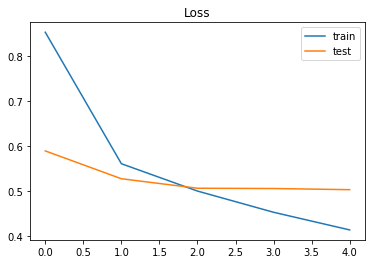

In [37]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

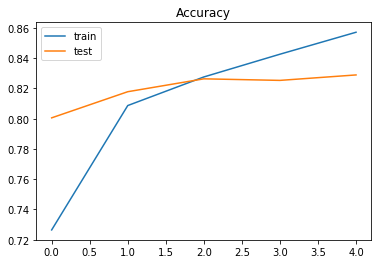

In [38]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [39]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

NameError: name 'pad_sequences' is not defined